# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract

import time
import random

from memory_profiler import profile

import FalseWordGenerator as FWG

import ALPHABET_8
ALPHABET = ALPHABET_8.ALPHABET
print (ALPHABET)

['a', 'e', 'i', 'n', 'o', 'r', 's', 't']


In [2]:
MEANINGFUL_WORDS = ALPHABET_8.WORDS
MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)
def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 2039
of which 1031 are positive
of which 1017 are negative


# Train and Extract with the optimal network

In [8]:
rnnOpt = RNNClassifier(ALPHABET,num_layers=3,hidden_dim=50,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


current average loss is:  0.3894663330420707
current average loss is:  0.17172273612644487
current average loss is:  0.026442623171996034


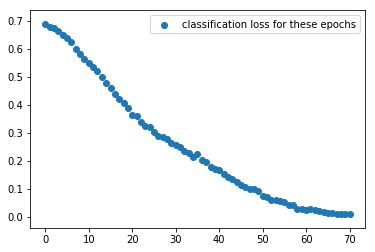

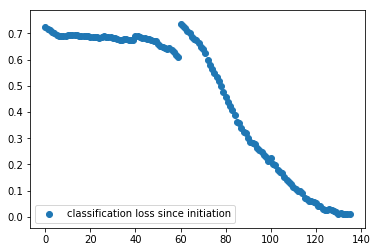

classification loss on last batch was: 0.009561155185772947


In [9]:
mixed_curriculum_train(rnnOpt,train_set,stop_threshold = 0.01)

In [10]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnOpt.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnOpt.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [11]:
rnnOpt.renew()

In [12]:
dfaOpt = extract(rnnOpt,time_limit = 60, initial_split_depth = 10, starting_examples = starting_examples)

provided counterexamples are: ['an', 'ot']
obs table refinement took 0.001
guided starting equivalence query for DFA of size 2
storing provided counterexample of length 2
returning counterexample of length 2:		ot, this counterexample is rejected by the given RNN.
equivalence checking took: 0.00034388699998544325
obs table refinement took 0.069
guided starting equivalence query for DFA of size 8
['', 'a']
refining, H size is 1
split wasn't perfect: gotta start over
['n', 'r']
['n', 'r', 't']
returning counterexample of length 2:		nn, this counterexample is rejected by the given RNN.
equivalence checking took: 0.5884843660001025
obs table refinement took 0.287
guided starting equivalence query for DFA of size 26
['n', 'r']
['n', 'r', 't']
refining, H size is 2
['ae', 'ai']
returning counterexample of length 3:		aet, this counterexample is rejected by the given RNN.
equivalence checking took: 0.014481600999943112
obs table refinement took 0.852
guided starting equivalence query for DFA of

# Cypher some messages

In [4]:
from MessageMaker import makeMessage

messageLength = 5

messages = []
for i in range (5):
    messages.append(makeMessage(MEANINGFUL_WORDS, messageLength))

In [5]:
import cypher_creation as c

rotationCypheredMessages = []
for message in messages:
    rotationCypheredMessages.append(c.rotate_sentence(message, ALPHABET))
    
swappedCypherMessages = []
for message in messages:
    swappedCypherMessages.append(c.swap_letters(message, ALPHABET)[0])  
                                    

# Attempt to crack the rotation cyphers

In [22]:
import Rotation_Checker as RCT

#def checkWithBruteForce(thisMessage, thisAlphabet, theseWords):
    
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    rnnReport = RCT.checkRtCy(rotationCypheredMessages[index], ALPHABET, rnnOpt)
    message = messages[index]
    #real: fart buffalo
    #return :asdjkfhaskljdfh asdljasl, aslhjkdlaskdlas, fart buffalo
    #1/3  %33.33%
    #real : this thing
    #returned : this thing
    #1/1 %100
    
    #real beef
    #return asdfhjakjsd asdhaskljdh 0%

    #This is accuracy
    
    #your percision take the average of the retuned score
    print(rnnReport)
rnnRunTime = time.time() - startTime
print (rnnRunTime)
startTime = time.time()
for message in rotationCypheredMessages:
    dfaReport = RCT.checkRtCy(message, ALPHABET, dfaOpt)
    #print(dfaReport)
dfaRunTime = time.time() - startTime
print (dfaRunTime)

#startTime = time.time()
#for message in rotationCypheredMessages:
#    bruteForceReport = checkWithBruteForce(message, ALPHABET, MEANINGFUL_WORDS)




72.42114114761353
0.5686628818511963


In [8]:
import Rotation_Checker as RCT
#CHECK WITH BRUTE FORCE
def checkWithBruteForce(thisMessage, thisAlphabet, theseWords):
    rotations = RCT.rtCyCdecode(thisMessage, thisAplhabet)
    print (rotations)
    
startTime = time.time()
for message in rotationCypheredMessages:
    bruteForceReport = checkWithBruteForce(message, ALPHABET, MEANINGFUL_WORDS)

NameError: name 'thisAplhabet' is not defined

# Attempt to crack the swap cyphers

In [3]:
import frequencyAnalysis as fa

from collections import Counter
SENTENCE="eat is ir tae ate"
output = fa.freqAnalysisSwap(MEANINGFUL_WORDS, SENTENCE)
print (output)

('ten sr sa net ent ', {'e': 't', 'a': 'e', 't': 'n', 'i': 's', 's': 'r', 'r': 'a'})


In [ ]:
#Call draw_nicely to hijack the dfa
dfaOpt.draw_nicely(maximum=300)

for index in range(len(swappedCypherMessages)):
    cypherMessage = swappedCypherMessages[index]
    message = messages[index]
    decypheredMessage = ""
    for word in cypherMessage.split():
        actualWord = dfaOpt.wordsWithWordnessScore(list(word))
        decypheredMessage += " " +"".join(actualWord)
    print(message)
    print(decypheredMessage)
        

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [ ]:
#from math import pow
#def percent(num,digits=2):
#    tens = pow(10,digits)
#    return str(int(100*num*tens)/tens)+"%"
#print("hello")
#dfaOpt.draw_nicely(maximum=300) #max size willing to draw
#print("hi")

#word = list("ASOI")
#actualWord = dfaOpt.wordsWithWordnessScore(word)
#print("originialWord :", actualWord)

In [ ]:
word = list("asoi")
actualWord = dfaOpt.wordsWithWordnessScore(word)
print("originialWord :", actualWord)


In [ ]:

from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfaOpt.draw_nicely(maximum=300) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")


Rotation Cypher Checker